In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt


from numpy import genfromtxt
import datetime

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, constraintASparse, plotSwitches, setupAxis

from model_loader import *
from price_loader import *
from color_loader import *

import switching_times_1st as st1
import switching_times_1st as st2

def plotSwitches(switches,t0,c1,c2,ax):
    n_s = int(len(switches)/2)
    for xc in switches[:n_s]:
        ax.axvline(x=xc+t0,color = c1, alpha = 0.2)
    
    for xc in switches[n_s:]:
        ax.axvline(x=xc+t0,color = c2, alpha = 0.2)

def modification_date(filename):
    t = os.path.getmtime(filename)
    return datetime.datetime.fromtimestamp(t)

import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

sns.set(style='ticks', palette="Paired")

%load_ext autoreload
%autoreload 2


/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [2]:
histories_m1 = {}
histories_m2 = {}
histories_m3 = {}
mod_times = []
for n_s in np.arange(4,22,2):
    model_sys = 'm1'
    filename = '../results/sim_history/og_history_(2018-01-01 12:00:00)_(20_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m3).npy'
    histories_m1[str(n_s)] = np.load(filename,allow_pickle=True).item()
    
    model_sys = 'm2'
    filename = '../results/sim_history/og_history_(2018-01-01 12:00:00)_(20_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m3).npy'
    histories_m2[str(n_s)] = np.load(filename,allow_pickle=True).item()
    
    model_sys = 'm3'
    filename = '../results/sim_history/og_history_(2018-01-01 12:00:00)_(20_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m3).npy'
    histories_m3[str(n_s)] = np.load(filename,allow_pickle=True).item()
    #mod_times.append(modification_date(filename))
    

# Compute computation time

In [3]:
m1_times = np.hstack([histories_m1[str(n_s)]['opt_time'] for n_s in np.arange(4,22,2)])
m2_times = np.hstack([histories_m2[str(n_s)]['opt_time'] for n_s in np.arange(4,22,2)])
m3_times = np.hstack([histories_m3[str(n_s)]['opt_time'] for n_s in np.arange(4,22,2)])

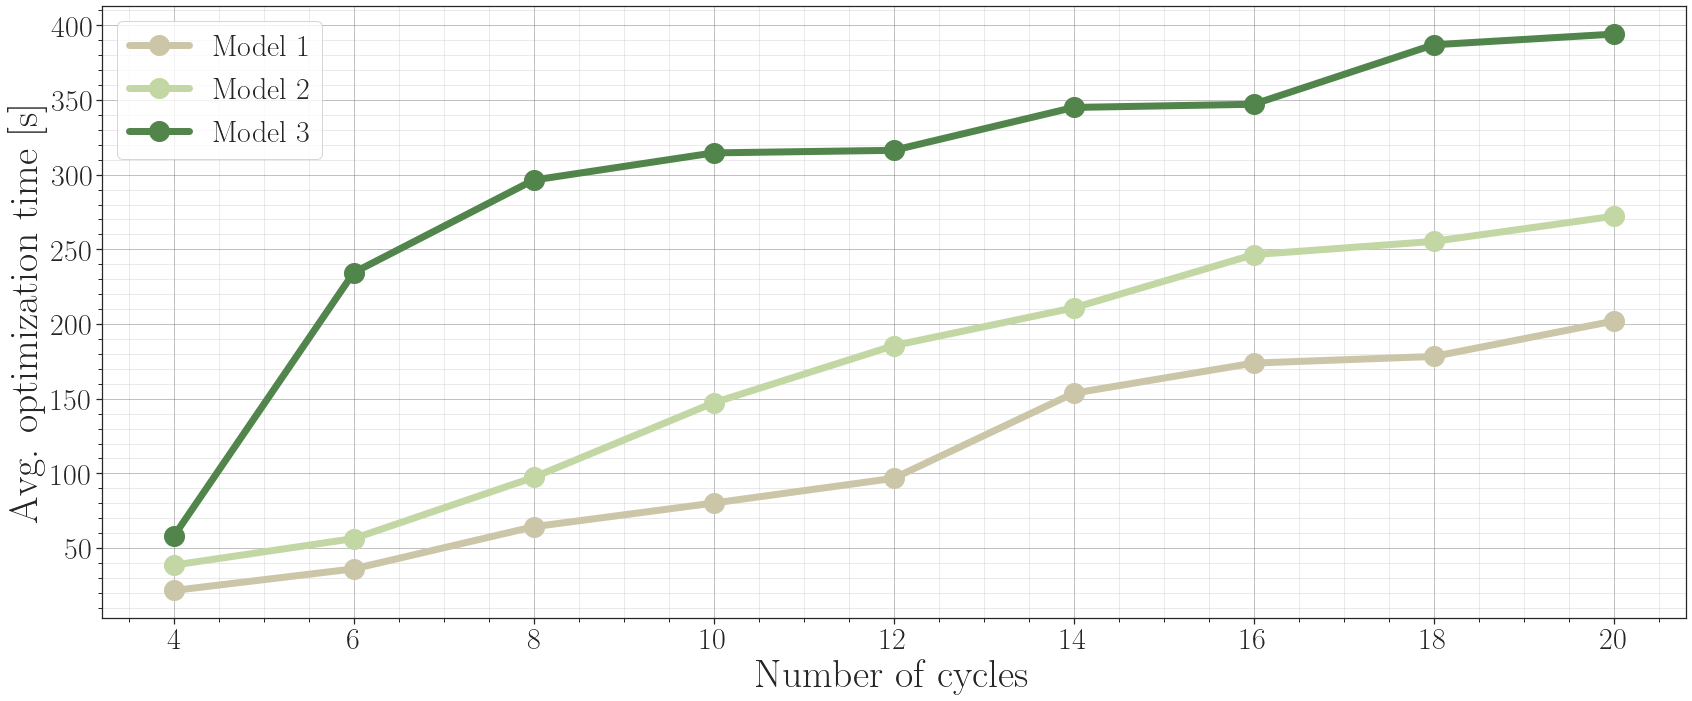

In [4]:
fig = plt.figure(figsize=(25,10))  

ax1 = fig.add_subplot(111)
markersize = 20
linewidth = 7
ax1.plot(np.arange(4,22,2),np.mean(m1_times,axis = 0),'-o',label=r'$\textnormal{Model 1}$',linewidth = linewidth,markersize = markersize,color = col_mod1_line)
ax1.plot(np.arange(4,22,2),np.mean(m2_times,axis = 0),'-o',label=r'$\textnormal{Model 2}$',linewidth = linewidth,markersize = markersize,color = col_mod2)
ax1.plot(np.arange(4,22,2),np.mean(m3_times,axis = 0),'-o',label=r'$\textnormal{Model 3}$',linewidth = linewidth,markersize = markersize,color = col_mod3)

setupAxis(ax1)
ax1.set_xlabel(r'$\textnormal{Number of cycles}$',fontsize = 40)
ax1.set_ylabel(r'$\textnormal{Avg. optimization time [s]}$',fontsize = 40)


plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_ns_cpu_time.pdf',format='pdf')



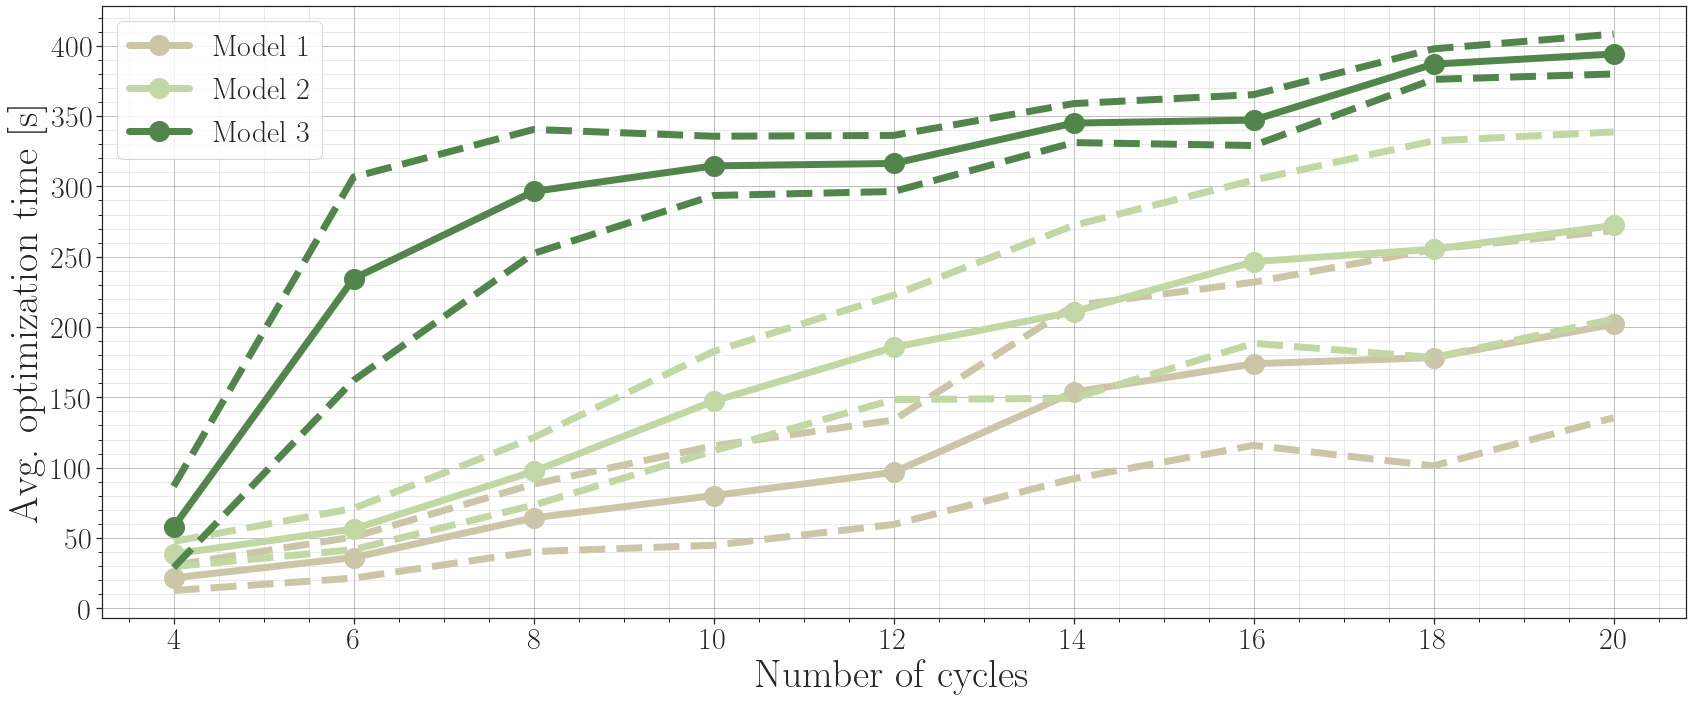

In [5]:
fig = plt.figure(figsize=(25,10))  

ax1 = fig.add_subplot(111)
markersize = 20
linewidth = 7
ax1.plot(np.arange(4,22,2),np.mean(m1_times,axis = 0),'-o',label=r'$\textnormal{Model 1}$',linewidth = linewidth,markersize = markersize,color = col_mod1_line)
ax1.plot(np.arange(4,22,2),(np.mean(m1_times,axis = 0) + 1*np.std(m1_times,axis = 0)),'--',label=r'',linewidth = linewidth,markersize = markersize,color = col_mod1_line)
ax1.plot(np.arange(4,22,2),(np.mean(m1_times,axis = 0) - 1*np.std(m1_times,axis = 0)),'--',label=r'',linewidth = linewidth,markersize = markersize,color = col_mod1_line)
ax1.plot(np.arange(4,22,2),np.mean(m2_times,axis = 0),'-o',label=r'$\textnormal{Model 2}$',linewidth = linewidth,markersize = markersize,color = col_mod2)
ax1.plot(np.arange(4,22,2),(np.mean(m2_times,axis = 0) + 1*np.std(m1_times,axis = 0)),'--',label=r'',linewidth = linewidth,markersize = markersize,color = col_mod2)
ax1.plot(np.arange(4,22,2),(np.mean(m2_times,axis = 0) - 1*np.std(m1_times,axis = 0)),'--',label=r'',linewidth = linewidth,markersize = markersize,color = col_mod2)
ax1.plot(np.arange(4,22,2),np.mean(m3_times,axis = 0),'-o',label=r'$\textnormal{Model 3}$',linewidth = linewidth,markersize = markersize,color = col_mod3)
ax1.plot(np.arange(4,22,2),(np.mean(m3_times,axis = 0) + 1*np.std(m3_times,axis = 0)),'--',label=r'',linewidth = linewidth,markersize = markersize,color = col_mod3)
ax1.plot(np.arange(4,22,2),(np.mean(m3_times,axis = 0) - 1*np.std(m3_times,axis = 0)),'--',label=r'',linewidth = linewidth,markersize = markersize,color = col_mod3)

setupAxis(ax1)
ax1.set_xlabel(r'$\textnormal{Number of cycles}$',fontsize = 40)
ax1.set_ylabel(r'$\textnormal{Avg. optimization time [s]}$',fontsize = 40)

plt.subplots_adjust(left = 0.07, right = 0.95, hspace=0.)

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/og_ns_cpu_time_with_std.pdf',format='pdf')



In [6]:
histories_m1 = {}
histories_m2 = {}
histories_m3 = {}
mod_times = []
for n_s in np.arange(4,22,2):
    model_sys = 'm1'
    filename = '../results/sim_history/og_history_reuse_(2018-01-01 12:00:00)_(20_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m3).npy'
    histories_m1[str(n_s)] = np.load(filename,allow_pickle=True).item()
    
    model_sys = 'm2'
    filename = '../results/sim_history/og_history_reuse_(2018-01-01 12:00:00)_(20_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m3).npy'
    histories_m2[str(n_s)] = np.load(filename,allow_pickle=True).item()
    
    model_sys = 'm3'
    filename = '../results/sim_history/og_history_reuse_(2018-01-01 12:00:00)_(20_days)' + '_(price_slope_' + str(0.2) +  ')_(regime_slope_' + str(0.2) +  ')_(seed_1235)_(n_s_' + str(n_s) + ')_(sys_model_' + model_sys + ')_(sys_true_m3).npy'
    histories_m3[str(n_s)] = np.load(filename,allow_pickle=True).item()
    

# Extract info

In [7]:
def extract_prices_per_day(histories):
    total_diff_ns = 9
    n_days = 20
    day_and_ns_each_day_1 = np.zeros((total_diff_ns,n_days))
    day_and_ns_acc_1 = np.zeros((total_diff_ns,n_days))
    idle_plan_each_day_1 = np.zeros((1,n_days))
    idle_plan_acc_1 = np.zeros((1,n_days))
    init_plan_each_day_1 = np.zeros((total_diff_ns,n_days))
    init_plan_acc_1 = np.zeros((total_diff_ns,n_days))

    for n_s_idx in range(total_diff_ns):
        for day in range(n_days):
    #n_s_idx = 0
            n_s = np.arange(4,22,2)[n_s_idx]
    #day = 0
            day_and_ns_acc_1[n_s_idx,day] = histories[str(n_s)]['price_true'][day][-1]
            day_and_ns_each_day_1[n_s_idx,day] = day_and_ns_acc_1[n_s_idx,day] - histories[str(n_s)]['price_true'][day][0]

            idle_plan_each_day_1[0,day] = histories[str(n_s)]['price_true_idle'][day][-1] - histories[str(n_s)]['price_true_idle'][day][0]
            idle_plan_acc_1[0,day] = histories[str(n_s)]['price_true_idle'][day][-1]

            init_plan_each_day_1[n_s_idx,day] = histories[str(n_s)]['price_true_init_switch'][day][-1] - histories[str(n_s)]['price_true_init_switch'][day][0]
            init_plan_acc_1[n_s_idx,day] = init_plan_each_day_1[n_s_idx,day]
            
    return day_and_ns_acc_1, day_and_ns_each_day_1, idle_plan_each_day_1, idle_plan_acc_1, init_plan_each_day_1, init_plan_acc_1

day_and_ns_acc_1, day_and_ns_each_day_1, idle_plan_each_day_1, idle_plan_acc_1, init_plan_each_day_1, init_plan_acc_1 = extract_prices_per_day(histories_m1)
day_and_ns_acc_2, day_and_ns_each_day_2, idle_plan_each_day_2, idle_plan_acc_2, init_plan_each_day_2, init_plan_acc_2 = extract_prices_per_day(histories_m2)
day_and_ns_acc_3, day_and_ns_each_day_3, idle_plan_each_day_3, idle_plan_acc_3, init_plan_each_day_3, init_plan_acc_3 = extract_prices_per_day(histories_m3)



# Compute Saving

In [8]:

def extract_saving_per_day(histories):
    total_diff_ns = 9
    n_days = 20
    day_and_ns_each_day_1 = np.zeros((total_diff_ns,n_days))
    day_and_ns_acc_1 = np.zeros((total_diff_ns,n_days))
    
    save_day_and_ns_each_day_1 = np.zeros((total_diff_ns,n_days))
    save_day_and_ns_acc_1 = np.zeros((total_diff_ns,n_days))

    for n_s_idx in range(total_diff_ns):
        for day in range(n_days):

            n_s = np.arange(4,22,2)[n_s_idx]
            day_and_ns_acc_1[n_s_idx,day] = histories[str(n_s)]['price_true'][day][-1]
            day_and_ns_each_day_1[n_s_idx,day] = day_and_ns_acc_1[n_s_idx,day] - histories[str(n_s)]['price_true'][day][0]

            idle_plan_each_day_1[0,day] = histories[str(n_s)]['price_true_idle'][day][-1] - histories[str(n_s)]['price_true_idle'][day][0]
            idle_plan_acc_1[0,day] = histories[str(n_s)]['price_true_idle'][day][-1]

            #init_plan_each_day_1[n_s_idx,day] = histories[str(n_s)]['price_true_init_switch'][day][-1] - histories[str(n_s)]['price_true_init_switch'][day][0]
            #init_plan_acc_1[n_s_idx,day] = init_plan_each_day_1[n_s_idx,day]
            
            
            save_day_and_ns_acc_1[n_s_idx,day] = (idle_plan_acc_1[0,day] - day_and_ns_acc_1[n_s_idx,day]) / (idle_plan_acc_1[0,day]  )
            save_day_and_ns_each_day_1[n_s_idx,day] = (idle_plan_each_day_1[0,day] - day_and_ns_each_day_1[n_s_idx,day]) / (idle_plan_each_day_1[0,day]  )
            
            
    return save_day_and_ns_acc_1, save_day_and_ns_each_day_1

save_day_and_ns_acc_1, save_day_and_ns_each_day_1 = extract_saving_per_day(histories_m1)
save_day_and_ns_acc_2, save_day_and_ns_each_day_2 = extract_saving_per_day(histories_m2)
save_day_and_ns_acc_3, save_day_and_ns_each_day_3 = extract_saving_per_day(histories_m3)




# Plot number of switches vs object function

No handles with labels found to put in legend.


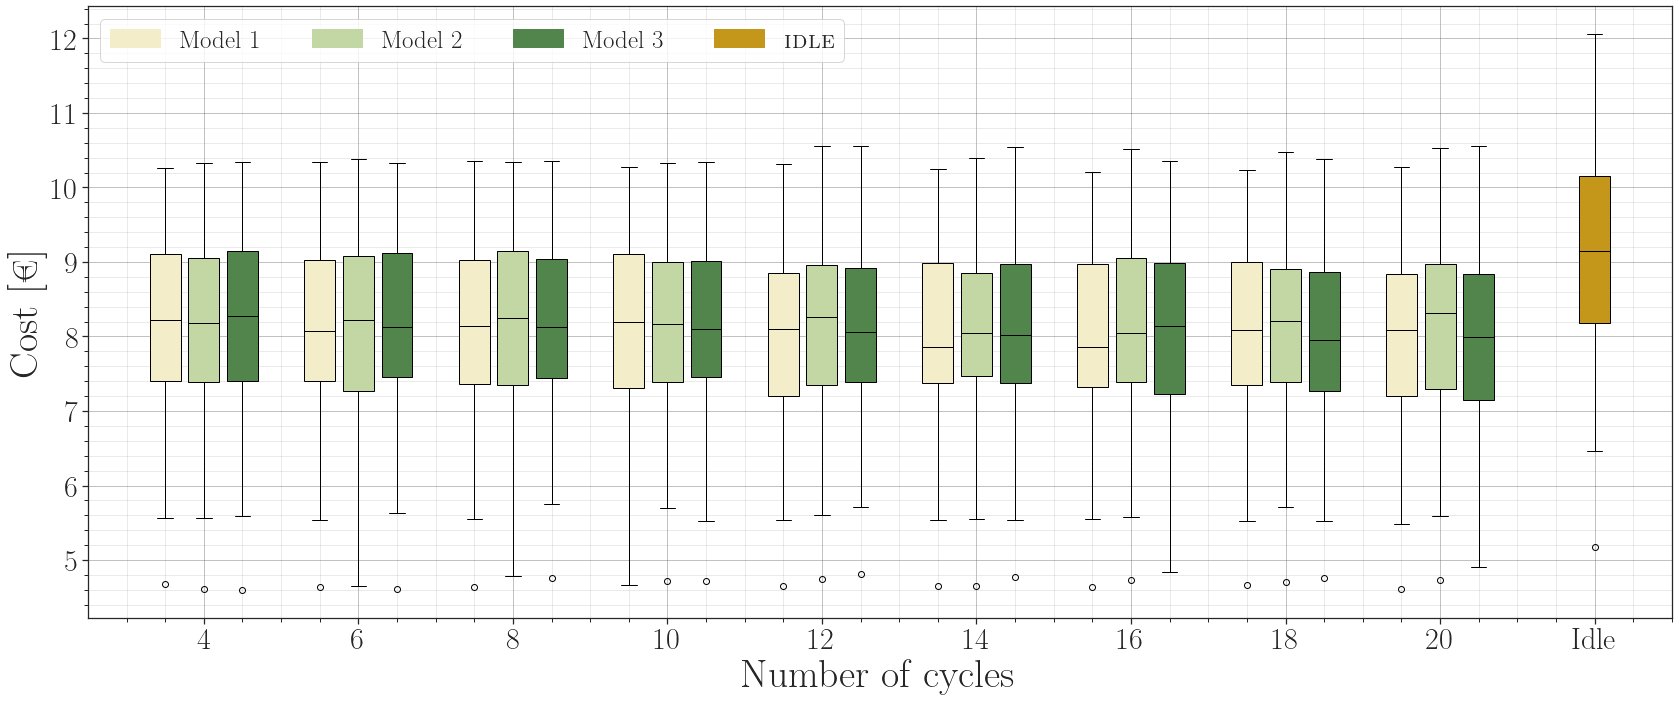

In [9]:
total_diff_ns = 9
def set_box_color(bp, color_box, color_whish, col_caps, col_median, col_fill):
    plt.setp(bp['boxes'], color=color_box)
    plt.setp(bp['whiskers'], color=color_whish)
    plt.setp(bp['caps'], color=col_caps)
    plt.setp(bp['medians'], color=col_median)
    
    for box in bp['boxes']:
        box.set(facecolor = col_fill) 
    
fig = plt.figure(figsize=(25,10))   
ax1 = fig.add_subplot(111)
boxplot_data_m1 = np.vstack( (day_and_ns_each_day_1))#,idle_plan_each_day_1))
boxplot_data_m2 = np.vstack( (day_and_ns_each_day_2))#,idle_plan_each_day_2))
boxplot_data_m3 = np.vstack( (day_and_ns_each_day_3))#,idle_plan_each_day_3))
bpl = ax1.boxplot(boxplot_data_m1.T, positions=np.array(range(len(boxplot_data_m1)))*2.0-0.5, widths=0.4, patch_artist=True)
bpr = ax1.boxplot(boxplot_data_m2.T, positions=np.array(range(len(boxplot_data_m2)))*2.0, widths=0.4, patch_artist=True)
bp3 = ax1.boxplot(boxplot_data_m3.T, positions=np.array(range(len(boxplot_data_m3)))*2.0+0.5, widths=0.4, patch_artist=True)
bp_idle = ax1.boxplot(idle_plan_each_day_3.T, positions=np.array(range(len(idle_plan_each_day_3)))+18., widths=0.4, patch_artist=True)
col_idle

#print(colors1[5])
set_box_color(bpl, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod1)
set_box_color(bpr, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod2)
set_box_color(bp3, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod3)
set_box_color(bp_idle, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_idle)
 
#bpl['boxes'].set(facecolor='#69b3a2')
#plt.setp(bpl["boxes"], facecolor='#69b3a2')
#set_box_color(bpr, color_box = '#2C7BB6', color_whish = '#2C7BB6', col_caps = '#2C7BB6', col_median = '#2C7BB6')

setupAxis(ax1)
a = [r'$' + str(2*(i+2)) + '$' for i in range(total_diff_ns)] #.append(r'Idle')
a.append(r'$\textnormal{Idle}$')
#ax1.set_xticklabels(['A', 'B', 'C'])
#ax1.set_xticks([1, 2, 3])
ax1.set_xticks(range(0,20,2))
ax1.set_xticklabels(np.array(a))
ax1.yaxis.grid(True) # Hide the horizontal gridlines
ax1.set_xlabel(r'$\textnormal{Number of cycles}$')
ax1.set_ylabel(r'$\textnormal{Cost [€]} $')
ax1.minorticks_on()
ax1.set_xlim(-1.5,19)
model1_patch = mpatches.Patch(color=col_mod1, label=r'$\textnormal{Model 1} $')
model2_patch = mpatches.Patch(color=col_mod2, label=r'$\textnormal{Model 2} $')
model3_patch = mpatches.Patch(color=col_mod3, label=r'$\textnormal{Model 3} $')
idle_patch = mpatches.Patch(color=col_idle, label=r'$\textsc{idle}$')
ax1.legend(handles=[model1_patch, model2_patch, model3_patch, idle_patch],prop={'size': 25},ncol=4)

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_ns_boxplot.pdf',format='pdf')


# Number of switches vs savings

No handles with labels found to put in legend.


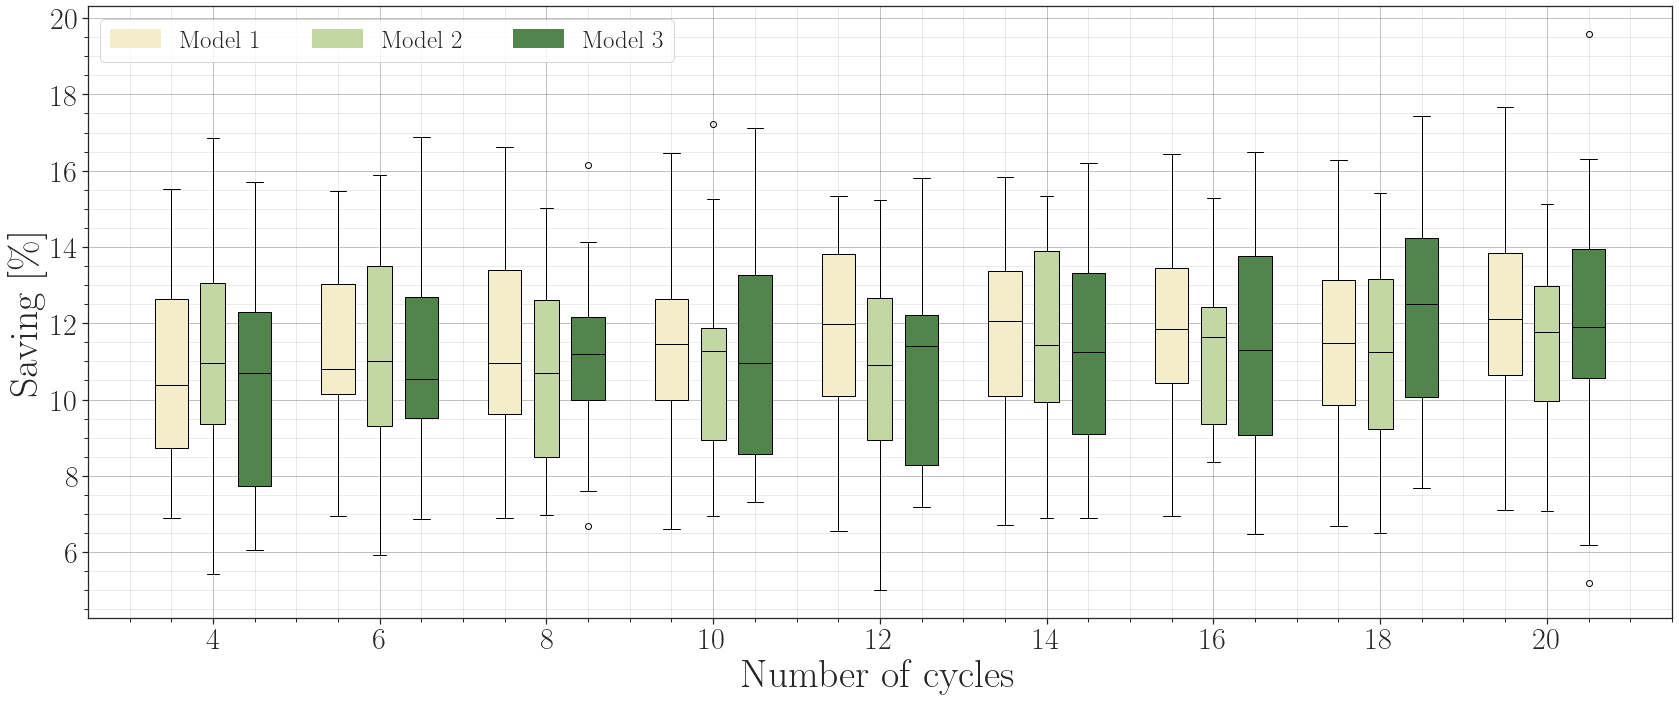

In [10]:
def set_box_color(bp, color_box, color_whish, col_caps, col_median, col_fill):
    plt.setp(bp['boxes'], color=color_box)
    plt.setp(bp['whiskers'], color=color_whish)
    plt.setp(bp['caps'], color=col_caps)
    plt.setp(bp['medians'], color=col_median)
    
    for box in bp['boxes']:
        box.set(facecolor = col_fill) 
    
fig = plt.figure(figsize=(25,10))   
ax1 = fig.add_subplot(111)
boxplot_data_m1 = np.vstack( (save_day_and_ns_each_day_1))
boxplot_data_m2 = np.vstack( (save_day_and_ns_each_day_2))
boxplot_data_m3 = np.vstack( (save_day_and_ns_each_day_3))
bpl = ax1.boxplot(100 * boxplot_data_m1.T, positions=np.array(range(len(boxplot_data_m1)))*2.0-0.5, widths=0.4, patch_artist=True)
bpr = ax1.boxplot(100 * boxplot_data_m2.T, positions=np.array(range(len(boxplot_data_m2)))*2.0, widths=0.3, patch_artist=True)
bp3 = ax1.boxplot(100 * boxplot_data_m3.T, positions=np.array(range(len(boxplot_data_m3)))*2.0+0.5, widths=0.4, patch_artist=True)


#print(colors1[5])
set_box_color(bpl, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod1)
set_box_color(bpr, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod2)
set_box_color(bp3, color_box = 'black', color_whish = 'black', col_caps = 'black', col_median = 'black',\
              col_fill = col_mod3)
 
#bpl['boxes'].set(facecolor='#69b3a2')
#plt.setp(bpl["boxes"], facecolor='#69b3a2')
#set_box_color(bpr, color_box = '#2C7BB6', color_whish = '#2C7BB6', col_caps = '#2C7BB6', col_median = '#2C7BB6')

setupAxis(ax1)
a = [r'$' + str(2*(i+2)) + '$' for i in range(total_diff_ns)] #.append(r'Idle')
#ax1.set_xticklabels(['A', 'B', 'C'])
#ax1.set_xticks([1, 2, 3])
ax1.set_xticks(range(0,20,2))
ax1.set_xticklabels(np.array(a))
ax1.yaxis.grid(True) # Hide the horizontal gridlines
ax1.set_xlabel(r'$\textnormal{Number of cycles}$')
ax1.set_ylabel(r'$\textnormal{Saving [\%]} $')
ax1.minorticks_on()
ax1.set_xlim(-1.5,17.5)
model1_patch = mpatches.Patch(color=col_mod1, label=r'$\textnormal{Model 1} $')
model2_patch = mpatches.Patch(color=col_mod2, label=r'$\textnormal{Model 2} $')
model3_patch = mpatches.Patch(color=col_mod3, label=r'$\textnormal{Model 3} $')
ax1.legend(handles=[model1_patch, model2_patch, model3_patch],prop={'size': 25},ncol=4)

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/spot_ns_boxplot_save.pdf',format='pdf')


# Optimized behaviour over 48 hours

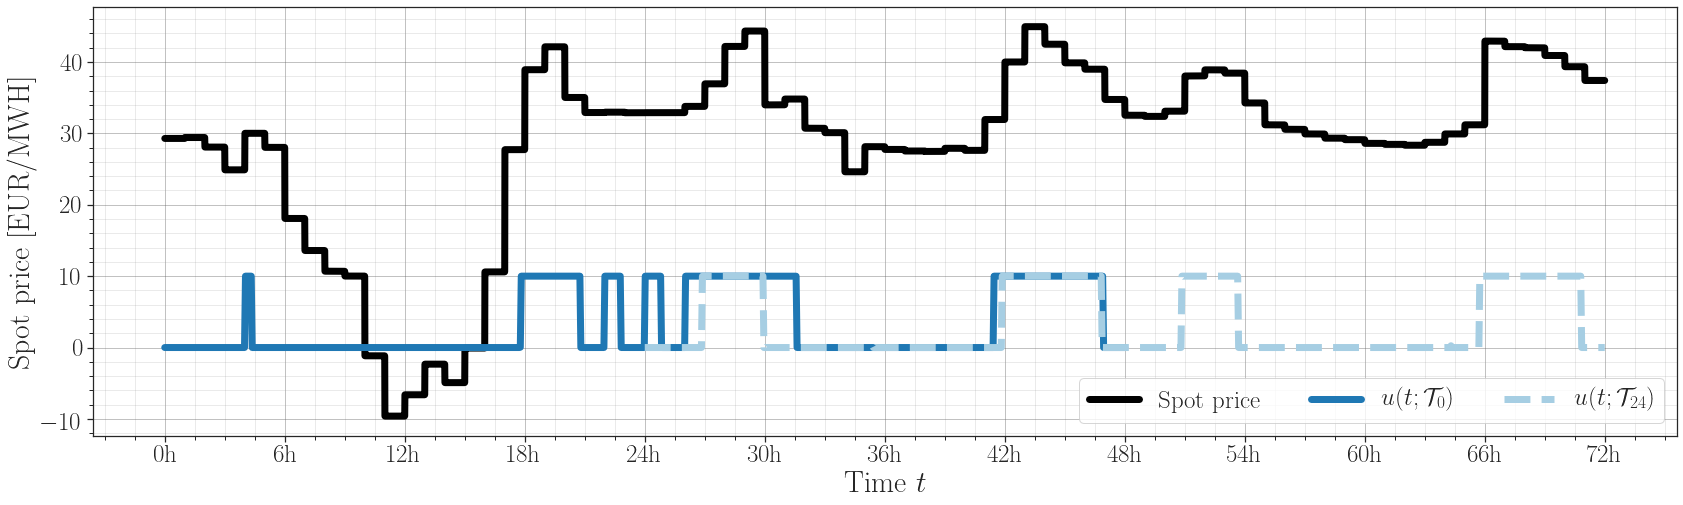

In [11]:
histories = histories_m1

fig = plt.figure(figsize=(25,7))   
ax1 = fig.add_subplot(111)

n_s = 10
day = 14
days_to_plot = range(day,day+3)

all_dap = np.concatenate([histories[str(n_s)]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[str(n_s)]['T'][0] + day * 60*24 for day in days_to_plot])
ax1.plot(all_time - days_to_plot[0]*24*60,smooth_dap(all_time - all_time[0],all_dap,slope = 20,n_hours=72),linewidth=7,color='black',label=r'$\textnormal{Spot price}$')
ax1.set_xticks(np.arange(0,3*25,6)*(60.))
ax1.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,3*25,6) * 60.])
#ax1.grid()


T1 = np.linspace(0,2*1440,1000)
T2 = np.linspace(1440,3*1440,1000)
ax1.plot(T1,10*smooth_regime(T1,histories[str(n_s)]['SWITCHES_dap'][days_to_plot[0]],10),linewidth=7,linestyle = '-',color=sns.color_palette("Paired")[1],label=r'$u(t;\mathcal{T}_0)$')
ax1.plot(T2,10*smooth_regime(T1,histories[str(n_s)]['SWITCHES_dap'][days_to_plot[1]],10),linewidth=7,linestyle = '--',color=sns.color_palette("Paired")[0],label=r'$u(t;\mathcal{T}_{24})$')
setupAxis(ax1)
ax1.legend(prop={'size': 25}, ncol = 3,loc='lower right')
ax1.tick_params(axis="both", labelsize=25)

# I want major ticks to be every 20
#major_ticks = np.arange(-24*60, 5*24*60, 24*60)

# I want minor ticks to be every 5
#minor_ticks = np.arange(-24*60, 5*24*60, 60)
#ax2.set_xticks(major_ticks)
#ax2.set_xticks(minor_ticks,minor=True)

#ax2.grid(b=False, which='major', axis='x')
#ax2.tick_params(axis = 'x', which = 'major', labelsize = 20)
#ax2.tick_params(axis = 'x', which = 'minor', labelsize =3)

#ax2.set_xticklabels(['',r'$\textnormal{0h}$',r'$\textnormal{24h}$',r'$\textnormal{48h}$',r'$\textnormal{72h}$'])
#ax2.set_xlim(-100,3*24*60 +100)
#ax2.set_ylim(-0.1,1.1)

ax1.set_xlabel(r'$\textnormal{Time } t$',size=30)
#ax2.set_ylabel(r'$\textnormal{SPot price }\frac{\textnormal{EUR}}{\textnormal{MWH}}$',size=30)
ax1.set_ylabel(r'$\textnormal{Spot price [EUR/MWH]}$',size=30)

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/test_og_example_of_opt.pdf',format='pdf')
#ax2.legend(prop={'size': 20},ncol=2)


In [13]:
#%%

import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, f_with_consumption, plotSwitches, f_with_cost, \
                    consumption, stochasticSimulation_IDLE, removeRedundantSwitches



#%load_ext autoreload
#%autoreload 2

# PATHS
#FIGS = '/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/THESIS/FIGS'

import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt


os.system("../model_loader.py")
os.system("../price_loader.py")
os.system("../../models/models.py")

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel


sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, f_with_consumption, plotSwitches, f_with_cost, \
                    consumption, stochasticSimulation_IDLE
from model_loader import *
from price_loader import *

# PATHS
#FIGS = '/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/THESIS/FIGS'

# Switching time optimization modules
import switching_times_1st as st1
import switching_times_2nd as st2
import switching_times_3rd as st3

import switching_times_1st_rk as st1_rk
import lxml

model_sys = 1
n_days = 1
n_s = 6
true_sys = 3
price_slope = 0.2
regime_slope = 0.2


k_baseline = 12400.
k_MELT = 250.
k_IDLE = 9.



# BUILD OPTIMIZATION FUNCTION
# Define parameters
#n_s = 6
max_melt = 8. * 60.
dt_opt = 0.1

# ------ Define models -------
# Expectation and optimization object model
# -------------
if model_sys == 1:
    print(1)
    system_model = m1; x0_model = x0_1; tank = st1.plant(); tank_pars = m1.drift_pars; sys_mod = 'm1'
elif model_sys == 2:
    print(2)
    system_model = m2; x0_model = x0_2_both_scaled; tank = st2.plant(); tank_pars = m2_both_scaled.drift_pars; sys_mod = 'm2'
elif model_sys == 3:
    print(3)
    system_model = m3; x0_model = x0_3; tank = st3.plant(); tank_pars = m3.drift_pars; sys_mod = 'm3'
# -------------

# "True" model
# -------------
if true_sys == 1:
    print(1)
    system_true = m1; x0_true = x0_1; sys_true = 'm1'
elif true_sys == 2:
    print(2)
    system_true = m2; x0_true = x0_2; sys_true = 'm2'
elif true_sys == 3:
    print(3)
    system_true = m3; x0_true = x0_3; sys_true = 'm3'
elif true_sys == 4: # With diffusion 0
    print(4)
    system_true = m3_zero_diff; x0_true = x0_3; sys_true = 'm4'
# -------------


#%%

#%%
# Build object
t0 = 0.
tf_sim = 60 * 24
tf_ph = 60 * 24
opt_rk = False
tank = build_initial_ipopt_object(tank, tank_pars, dt_opt, k_baseline, k_MELT, k_IDLE, t0, tf_ph, max_melt, n_s, price_slope, regime_slope, opt_rk)


# Build initial switches
# Build initial values - Other methods could be considered
idle = tf_ph * np.linspace(0.1,0.9,n_s) # Spread out on the whole interval
melt = idle - max_melt/n_s * 0.866 # Assign melt period to a little before idle
switch0_dap = np.concatenate((melt,idle)) # put together

switch0 = switch0_dap

tank.set_p_optimize(switch0)

# Build initial switches
# Build initial values - Other methods could be considered
idle = tf_ph * np.linspace(0.1,0.9,n_s) # Spread out on the whole interval
melt = idle - max_melt/n_s * 0.866 # Assign melt period to a little before idle
switch0_dap = np.concatenate((melt,idle)) # put together

switch0 = switch0_dap

tank.set_p_optimize(switch0)


#%%
# SIMUALTE
#n_days = 2
n_skip = 20 #int(1/ och_sim)
start_date = '2018-01-01 12:00:00'
dt_stoch_sim = 0.1
seed = 1235

# Derive convenient parameters
np.random.seed(1234)
n_per_day =  int(1/n_skip * 1/dt_stoch_sim *60 * 24)
t0_sim = t0
t0_ph = t0
total_sim_time = tf_sim - t0_sim

# Initialize processes
nx_true = x0_true.size
nx_model = x0_model.size


price_true_lasthour = 0.
price_true_lasthour_init_switch = 0.
price_true_lasthour_idle = 0.
price_promised_lasthour = 0.

cons_true_lasthour = 0.
cons_true_lasthour_init_switch = 0.
cons_true_lasthour_idle = 0.
cons_promised_lasthour = 0.

start_true = np.array(x0_true)
start_true_init_switch = np.array(x0_true)
start_true_idle = np.array(x0_true)
start_promised = np.array(x0_model)

idx_offset = np.where(prices.index == start_date)[0][0]


day = 14
    
t0_sub = t0_sim/24.
tf_sub = tf_sim/24.

# Extract prices for optimization
idx_offset = np.where(prices.index == start_date)[0][0]
idx = np.arange(48) + day * 24 + idx_offset
q_dap = np.array(prices['spot'][idx]).astype(np.float) # * 1/1000000

# Insert new prices in optimization object
p_dynamic = tank.get_p_dynamic()
for k in range(0, 48):
    p_dynamic[k] = q_dap[k]
    #p_dynamic[48 + k] = q_rk[k]
    tank.set_p_dynamic(p_dynamic)

# Initial state of the system
start_promised = start_promised # Should be estimated with Kalman Filter
tank.set_x0(np.append(start_promised,0)) 

# Find optimal switches
init_switch = tank.get_p_optimize()
print(' ... Started optimizing')
time_start = time.time()
tank.solve()
print(' ... Finished optimizing')
opt_switch = tank.get_p_optimize_ipopt()
switch_promised = opt_switch[:2*n_s]
#switch_used = opt_switch[2*n_s:]
    
  


1
3
 ... Started optimizing
 ... Finished optimizing


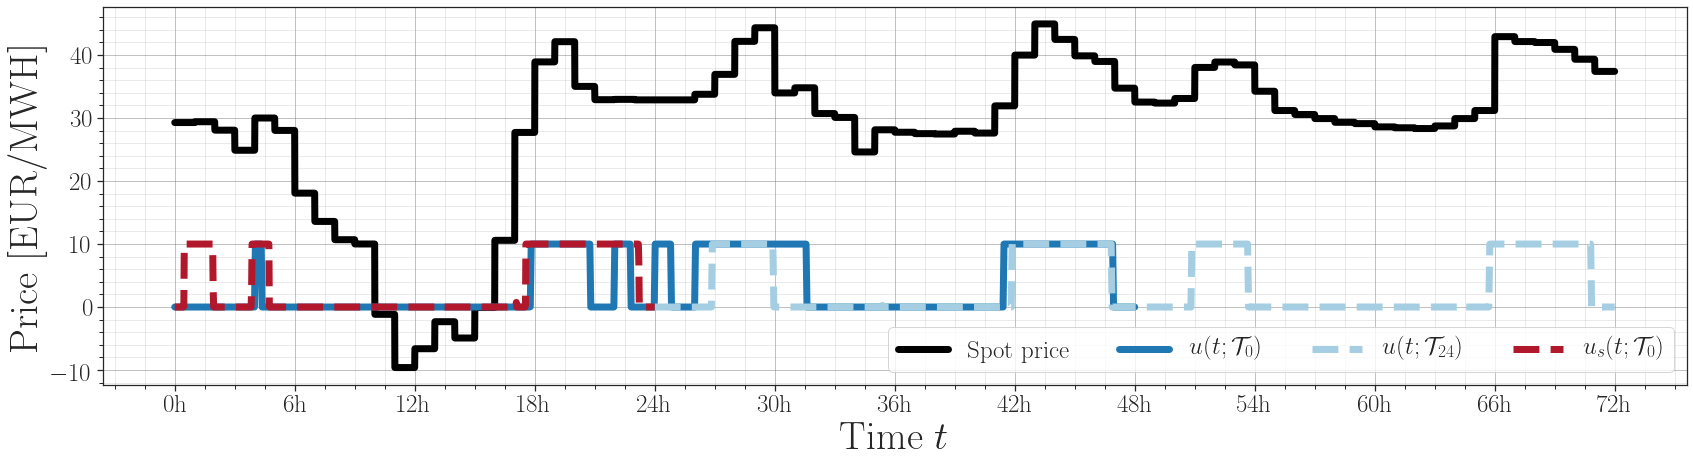

In [17]:
histories = histories_m1

fig = plt.figure(figsize=(25,7))   
ax1 = fig.add_subplot(111)

n_s = 10
days_to_plot = range(day,day+3)

all_dap = np.concatenate([histories[str(n_s)]['PRICES_dap'][day,:24] for day in days_to_plot])
all_time = np.concatenate([histories[str(n_s)]['T'][0] + day * 60*24 for day in days_to_plot])
ax1.plot(all_time - days_to_plot[0]*24*60,smooth_dap(all_time - all_time[0],all_dap,slope = 200,n_hours=72),linewidth=7,color='black',label=r'$\textnormal{Spot price}$')
ax1.set_xticks(np.arange(0,3*25,6)*(60.))
ax1.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(0,3*25,6) * 60.])
#ax1.grid()


T1 = np.linspace(0,2*1440,1000)
T2 = np.linspace(1440,3*1440,1000)
T3 = np.linspace(0,1440,1000)
ax1.plot(T1,10*smooth_regime(T1,histories[str(n_s)]['SWITCHES_dap'][days_to_plot[0]],10),linewidth=7,linestyle = '-',color=sns.color_palette("Paired")[1],label=r'$u(t;\mathcal{T}_0)$')
ax1.plot(T2,10*smooth_regime(T1,histories[str(n_s)]['SWITCHES_dap'][days_to_plot[1]],10),linewidth=7,linestyle = '--',color=sns.color_palette("Paired")[0],label=r'$u(t;\mathcal{T}_{24})$')
ax1.plot(T3,10*smooth_regime(T3,switch_promised,10),linewidth=7,linestyle = '--',color=dark_red,label=r'$u_{s}(t;\mathcal{T}_{0})$')
setupAxis(ax1)
ax1.legend(prop={'size': 25}, ncol = 4,loc='lower right')
ax1.tick_params(axis="both", labelsize=25)

# I want major ticks to be every 20
#major_ticks = np.arange(-24*60, 5*24*60, 24*60)

# I want minor ticks to be every 5
#minor_ticks = np.arange(-24*60, 5*24*60, 60)
#ax2.set_xticks(major_ticks)
#ax2.set_xticks(minor_ticks,minor=True)

#ax2.grid(b=False, which='major', axis='x')
#ax2.tick_params(axis = 'x', which = 'major', labelsize = 20)
#ax2.tick_params(axis = 'x', which = 'minor', labelsize =3)

#ax2.set_xticklabels(['',r'$\textnormal{0h}$',r'$\textnormal{24h}$',r'$\textnormal{48h}$',r'$\textnormal{72h}$'])
#ax2.set_xlim(-100,3*24*60 +100)
#ax2.set_ylim(-0.1,1.1)

ax1.set_xlabel(r'$\textnormal{Time } t$',size=40)
#ax2.set_ylabel(r'$\textnormal{SPot price }\frac{\textnormal{EUR}}{\textnormal{MWH}}$',size=30)
ax1.set_ylabel(r'$\textnormal{Price [EUR/MWH]}$',size=40)

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
plt.savefig(FIGS + '/simulation/test_og_example_of_opt_with_short.pdf',format='pdf')

